# Train a simple autoencoder for MNIST with 3 Hidden Layers

The autoencoder trained here has three regularizers added to the reconstruction error, that enforce sparsity within a layer, participation of all neurons in the network and binary output behavior of binomial units.

I.e., the loss function consists of a term, that evaluates the error between the input and output 
**plus** a term, that evaluates the sparsity in the hidden layers
**plus** a term, that makes sure, that all neurons are active every once in a while
**plus** a term, that punishes output activations that deviate from 0 or 1.

## Participation

To ensure, that a neuron participates on the computation, we need to consider its activity over time, which makes training harder, as we need to backprop over many trials to be correct, because the activity trace denpends on all previous trials.

Instead of simulating many trials before starting backprop, we maintain the activity trace outside of the tensorflow simulation. I.e., it will be an external input to the network.
Note, that the term we add then to the loss is still convex:

\begin{equation}
(\gamma \cdot x_{trace} + (1-\gamma) \cdot x - (1-sparsity))^2
\end{equation}

where x_trace is the activity trace which is fed to the network externally.

We initialize x_trace to be sparsity. I.e., at the beginning, no error is measured through the above loss until we get a divergence of x_trace from sparsity.

Note, the above equation is not stable. For a sophisticated and more stable version, pls. refer to the enclosed PDF.

## Sparsity

Assume we have a level of sparsity $s$ that should be inferred. Given binary units and $p=1-s$, the number of units active at a timestep in a layer with $N$ neurons is $k = p \cdot N$. We call $p$ participation.

The loss can therefore be computed in hidden layer $h$ as

\begin{equation}
(\frac{1}{N} \sum_{i} h_i - p)^2
\end{equation}

## Binary Activation

As we are using sigmoid units (but want to infer properties about binary units), we want to additionally enforce a binary behavior of the units here. I.e., a neural activation $h_i$ should be either 0 or 1.

\begin{equation}
(h_i - 0)^2 \cdot (h_i - 1)^2
\end{equation}

Note, this loss is not convex.

In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import math

import numpy as np

from IPython.display import HTML

%matplotlib inline

# Download and read mnist data
mnist = input_data.read_data_sets('mnist_data', one_hot=True)

Extracting mnist_data/train-images-idx3-ubyte.gz
Extracting mnist_data/train-labels-idx1-ubyte.gz
Extracting mnist_data/t10k-images-idx3-ubyte.gz
Extracting mnist_data/t10k-labels-idx1-ubyte.gz


Starting training ...
step 0, training loss 4.00305


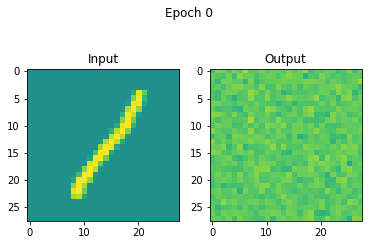

step 1000, training loss 0.566205


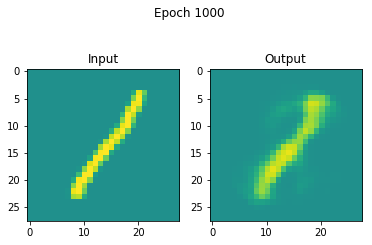

step 2000, training loss 0.437919


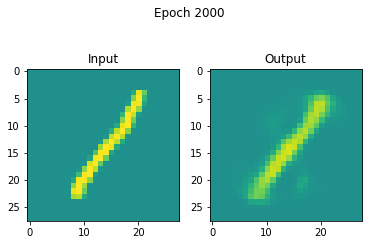

step 3000, training loss 0.413145


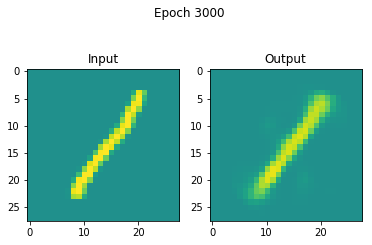

step 4000, training loss 0.415434


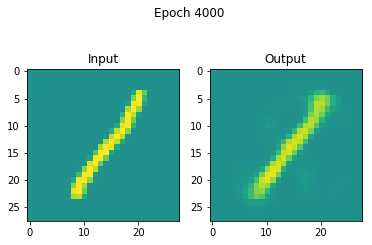

step 5000, training loss 0.334588


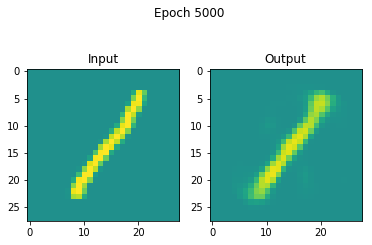

step 6000, training loss 0.323634


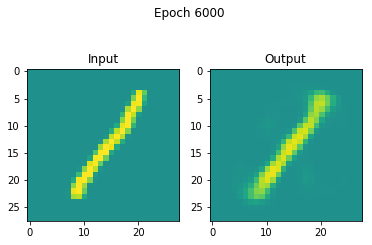

step 7000, training loss 0.320904


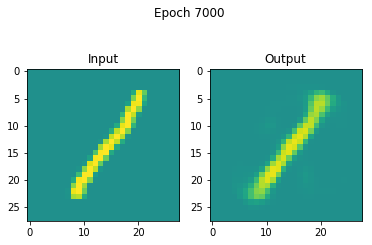

step 8000, training loss 0.321784


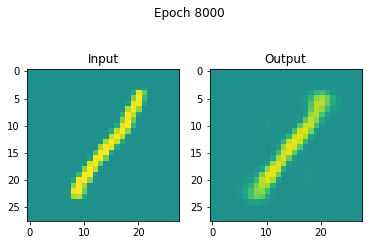

step 9000, training loss 0.299566


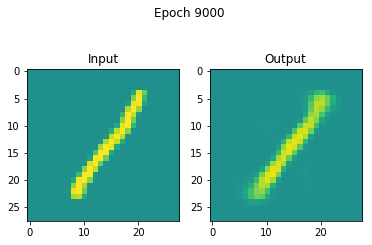

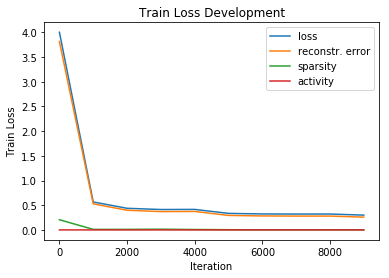

In [2]:
tf.reset_default_graph()

# Exponential smoothing factor.
gamma = 0.99

sparsity = 0.75
# Influence of sparsity constraint to loss
alph_s = 0.5
# Influence of participation constraint to loss
alph_p = 100.0
# Influence of the binary output constraint to the loss
alph_b = 0.5

size_input = 784
size_h1 = 200
size_h2 = 30

# Initial learning rate
lr = 100


def sshift(c, k=100.):
    """How to shift the sigmoid along the x-axis, such that sigmoid(0) = c.

    Args:
        c: y-value of sigmoid(0).
        k: Stretching factor of sigmoid.

    Returns:
        Returns x_s such that sigmoid(x-x_s) = c for x = 0. Note, that the original sigmoid has the property that
        sigmoid(x) = 0.5 for x = 0.
    """
    return 1./k * tf.log((1.-c)/c)

def sigmoid(x, x_s, k=100.):
    """Compute a sigmoid fuction.

    Args:
        x: Input to sigmoid
        c: y-value of sigmoid(0).
        k: Stretching factor of sigmoid.

    Returns:
        Returns 1/(1+exp(-k*(x-x_s)))
    """
    return tf.div(1.,tf.add(1.,tf.exp(-k * (x-x_s))))

# Create a five layer fully-connected network:
# size_input -> size_h1 -> size_h2 -> size_h1 -> size_input
inputs = tf.placeholder(tf.float32, shape=[None, size_input])
learning_rate = tf.placeholder(tf.float32, shape=[])

activity_trace_h1 = tf.placeholder(tf.float32, shape=[size_h1])
activity_trace_h2 = tf.placeholder(tf.float32, shape=[size_h2])
activity_trace_h3 = tf.placeholder(tf.float32, shape=[size_h1])

h1 = tf.contrib.layers.fully_connected(inputs, size_h1, activation_fn=tf.nn.sigmoid)

h2 = tf.contrib.layers.fully_connected(h1, size_h2, activation_fn=tf.nn.sigmoid)

h3 = tf.contrib.layers.fully_connected(h2, size_h1, activation_fn=tf.nn.sigmoid)

outputs = tf.contrib.layers.fully_connected(h3, size_input, activation_fn=tf.nn.sigmoid)

# Reconstruction Error
# As the other loss terms (e.g. sparsity) are normalized to layer sizes, we should do this here too
# Note, that the function L2 loss doesn't use the sqrt op.
rec_err = tf.nn.l2_loss(outputs-inputs) / float(size_input)

# Compute sparsity within layer
# (We only consider hidden layers, as the other layer shall be fully governed by the input)
loss_s = 0
# Compute binary loss.
loss_b = 0
for layer in [h1,h2,h3]:
    n_l = float(int(layer.shape[1]))
    participation = (1.-sparsity)
    loss_s += tf.reduce_mean(tf.reduce_sum(layer, 1)/n_l - participation)**2
    
    loss_b += tf.reduce_mean(tf.pow(layer,2)*tf.pow(layer-1,2))
    
# Add participation loss for all neurons
loss_p = 0
activity_traces = [activity_trace_h1, activity_trace_h2, activity_trace_h3]
participation = (1.-sparsity)
x_s = sshift(participation) # sigmoid shift
for ii, layer in enumerate([h1,h2,h3]):
    n_l = float(int(layer.shape[1]))
    a_trace = activity_traces[ii]
    
    ## Simple loss (unstable minima)
    #loss_p += tf.reduce_mean(tf.reduce_sum((gamma*a_trace + (1-gamma)*layer - participation)**2, 1)/n_l)
    
    ## Loss with minimas relatively stable around 0 or 1 (depending on trace error)
    # Root of the simple loss formulation.
    root = - 1/(1-gamma) * (gamma*a_trace - participation)
    sigval = sigmoid(participation - a_trace, x_s)
    loss_p += tf.reduce_mean(tf.reduce_sum( \
        (gamma*a_trace + (1-gamma)*layer - participation + (1-gamma) * (root - sigval))**2, 1)/n_l)
    
loss = rec_err + alph_s * loss_s + alph_p * loss_p + alph_b * loss_b

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

tf.set_random_seed(42)

train_step = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss)

print('Starting training ...')

# Choose a test sample, which will show the training progress during eval iterations.
test_batch = mnist.test.next_batch(1)

loss_values = []

# Monitor the hidden activations, to visualize the sparsity.
hidden_activations = []

# Monitor the activation traces to visualize their evolution.
activation_traces_train = []

batch_size = 32

# Initial activation traces.
#at_h1 = np.expand_dims(np.ones(size_h1) * sparsity, axis=0)
at_h1 = np.ones(size_h1) * (1-sparsity)
at_h2 = np.ones(size_h2) * (1-sparsity)
at_h3 = np.ones(size_h1) * (1-sparsity)

for i in range(10000):
    batch = mnist.train.next_batch(batch_size)
    
    # Eval current training stage
    if i % 1000 == 0:
        lr /= 2
        train_loss, train_err, train_sp, train_a = sess.run([loss, rec_err, loss_s, loss_p], feed_dict={
            inputs: batch[0], learning_rate: lr, \
            activity_trace_h1: at_h1, activity_trace_h2: at_h2, activity_trace_h3: at_h3})
        
        loss_values.append((i, train_loss, train_err, train_sp, train_a))
        print("step %d, training loss %g" \
              % (i, train_loss))
        
        # Evaluation on test sample
        h1_activity, h2_activity, h3_activity = sess.run([h1,h2,h3], feed_dict={
            inputs: test_batch[0], learning_rate: lr, \
            activity_trace_h1: at_h1, activity_trace_h2: at_h2, activity_trace_h3: at_h3})
        
        hidden_activations.append((i, h1_activity, h2_activity, h3_activity))
        
        activation_traces_train.append((i, at_h1, at_h2, at_h3))

        outs = outputs.eval(feed_dict={
                    inputs: test_batch[0], learning_rate: lr, \
            activity_trace_h1: at_h1, activity_trace_h2: at_h2, activity_trace_h3: at_h3})
        fig = plt.figure()
        plt.suptitle('Epoch %d' % (i))
        ax = fig.add_subplot(1,2,1)
        ax.imshow(test_batch[0].reshape((28,28)), vmin=-1.0, vmax=1.0)
        ax.set_title('Input')
        ax = fig.add_subplot(1,2,2)
        ax.imshow(outs.reshape((28,28)), vmin=-1.0, vmax=1.0)
        ax.set_title('Output')
        plt.show()
        
    # Run backprop
    train_step.run(feed_dict={inputs: batch[0], learning_rate: lr, \
            activity_trace_h1: at_h1, activity_trace_h2: at_h2, activity_trace_h3: at_h3})
    
    # Update activity traces
    activity_h1, activity_h2, activity_h3 = sess.run([h1, h2, h3], feed_dict={inputs: batch[0], learning_rate: lr, \
        activity_trace_h1: at_h1, activity_trace_h2: at_h2, activity_trace_h3: at_h3})
    # We update the traces by the mean activity achieved in the current batch
    activity_h1 = np.mean(activity_h1, axis=0)
    activity_h2 = np.mean(activity_h2, axis=0)
    activity_h3 = np.mean(activity_h3, axis=0)
    
    at_h1 = gamma * at_h1 + (1-gamma) * activity_h1
    at_h2 = gamma * at_h2 + (1-gamma) * activity_h2
    at_h3 = gamma * at_h3 + (1-gamma) * activity_h3
    
xval, lval, erval, sval, aval = zip(*loss_values)
plt.plot(xval, lval, label="loss")
plt.plot(xval, erval, label="reconstr. error")
plt.plot(xval, sval, label="sparsity")
plt.plot(xval, aval, label="activity")
plt.legend()
plt.title("Train Loss Development")
plt.xlabel("Iteration")
plt.ylabel("Train Loss")
plt.show()

# Evolution of activity histograms to visualize sparsity

Here we plot histograms of the hidden layer activation over time. I.e., at each evaluation epoch, we take the activation of all hidden layers and plot a histogram of the contained values (bins of size 0.1). Ideally, (1-sparsity)% of the activations have the value one and sparsity% of the values have the value zero. However, it is hard to define a regularizer for sigmoid units, that enforces this behavior.

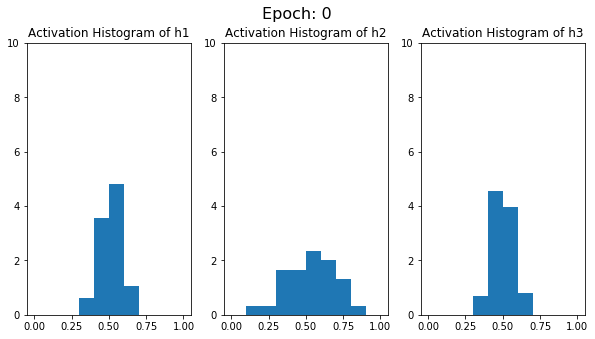

In [3]:
xval, h1val, h2val, h3val = zip(*hidden_activations)

number_of_frames = len(xval)

def update_hist(num):
    plt.cla()
    ax1.cla()
    ax2.cla()
    ax3.cla()
    
    ax1.set_ylim(0.0, 10.0)
    ax2.set_ylim(0.0, 10.0)
    ax3.set_ylim(0.0, 10.0)
    
    fig.suptitle('Epoch: %d' % xval[num], fontsize=16)
    
    ax1.hist(np.squeeze(h1val[num]), bins=np.linspace(0,1,11), range=(0.,1.), normed=True) 
    ax1.set_title('Activation Histogram of h1')

    ax2.hist(np.squeeze(h2val[num]), bins=np.linspace(0,1,11), range=(0.,1.), normed=True) 
    ax2.set_title('Activation Histogram of h2')

    ax3.hist(np.squeeze(h3val[num]), bins=np.linspace(0,1,11), range=(0.,1.), normed=True) 
    ax3.set_title('Activation Histogram of h3')

fig = plt.figure(figsize = (10,5))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

update_hist(0)

anim = animation.FuncAnimation(fig, update_hist, number_of_frames, interval=1000 )
#plt.show()
HTML(anim.to_html5_video())

# Evolution of activity trace histograms to visualize participation

Here we plot histograms of the hidden layer activity traces over time. I.e., at each evaluation epoch, we take a snapshot of the current activity trace for all hidden neurons. **Note**, unlike the hidden activations, the activity traces here are not monitored over a single test sample (as we would need to simulate the test sample every iteration). Instead, the activity trace is the same as used for training, thus it is computed from mean activations of training batches.

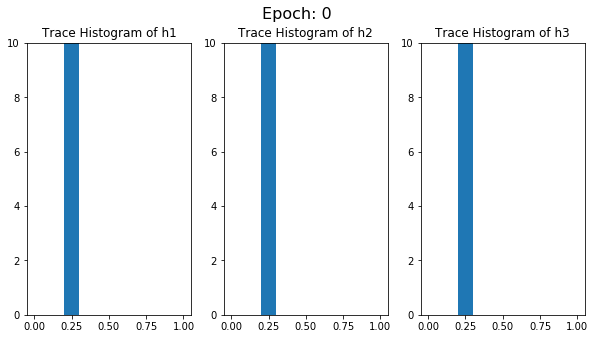

In [4]:
xval, h1val, h2val, h3val = zip(*activation_traces_train)

number_of_frames = len(xval)

def update_hist(num):
    plt.cla()
    ax1.cla()
    ax2.cla()
    ax3.cla()
    
    ax1.set_ylim(0.0, 10.0)
    ax2.set_ylim(0.0, 10.0)
    ax3.set_ylim(0.0, 10.0)
    
    fig.suptitle('Epoch: %d' % xval[num], fontsize=16)
    
    ax1.hist(np.squeeze(h1val[num]), bins=np.linspace(0,1,11), range=(0.,1.), normed=True) 
    ax1.set_title('Trace Histogram of h1')

    ax2.hist(np.squeeze(h2val[num]), bins=np.linspace(0,1,11), range=(0.,1.), normed=True) 
    ax2.set_title('Trace Histogram of h2')

    ax3.hist(np.squeeze(h3val[num]), bins=np.linspace(0,1,11), range=(0.,1.), normed=True) 
    ax3.set_title('Trace Histogram of h3')

fig = plt.figure(figsize = (10,5))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

update_hist(0)

anim = animation.FuncAnimation(fig, update_hist, number_of_frames, interval=1000 )
#plt.show()
HTML(anim.to_html5_video())

# Test samples

Random test samples from the test set to get an subjective impression of the autoencoder quality.

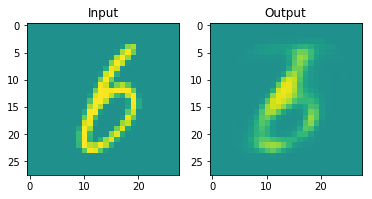

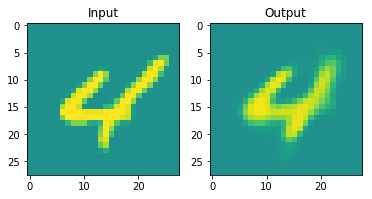

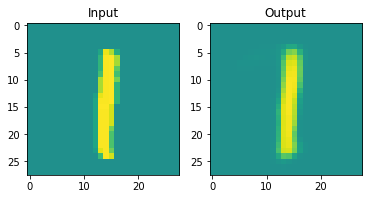

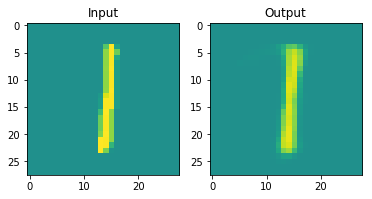

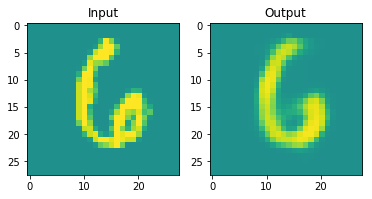

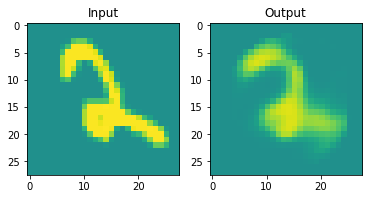

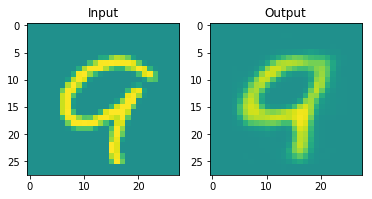

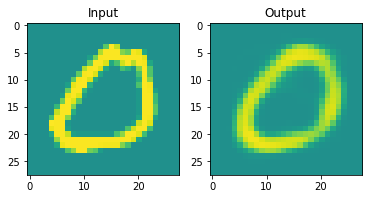

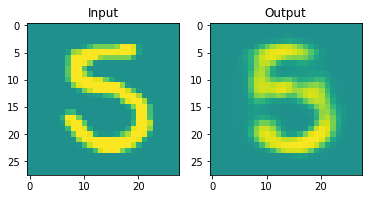

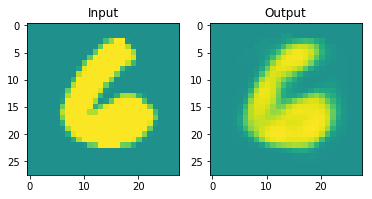

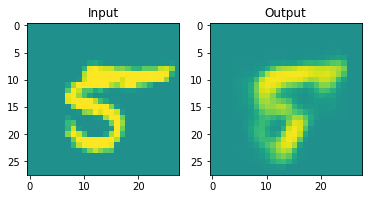

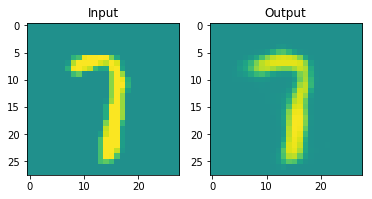

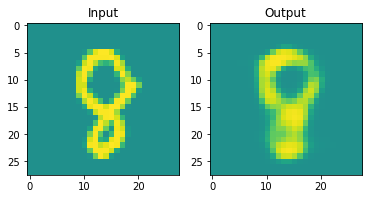

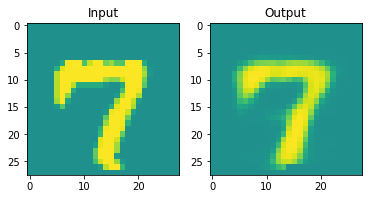

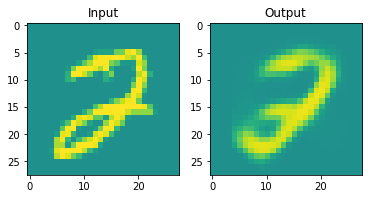

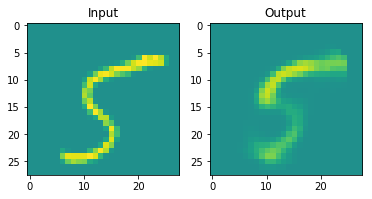

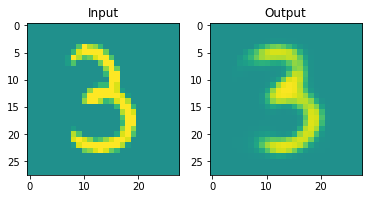

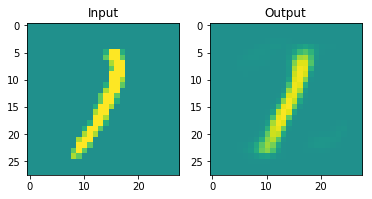

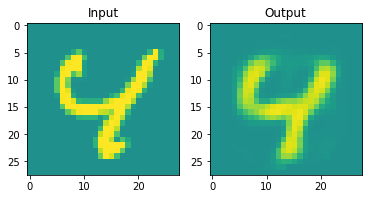

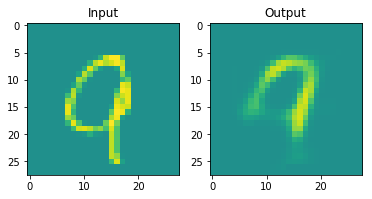

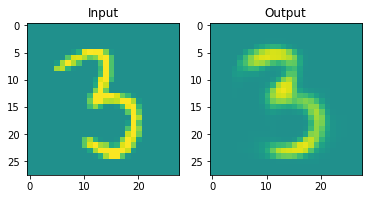

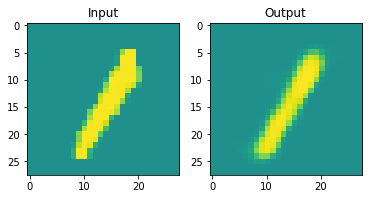

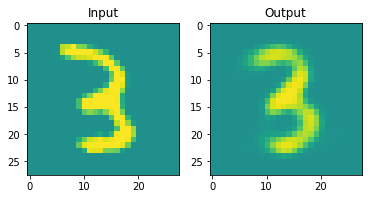

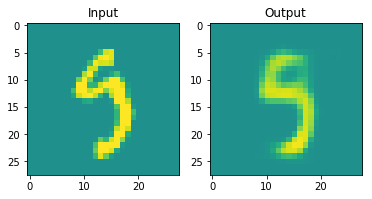

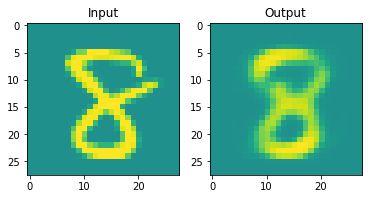

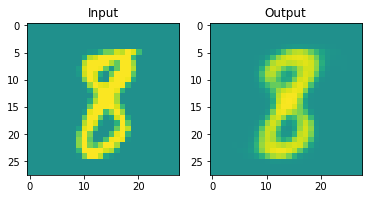

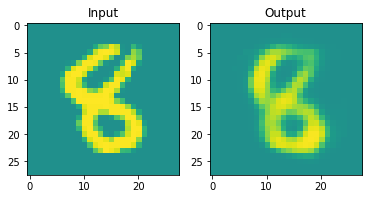

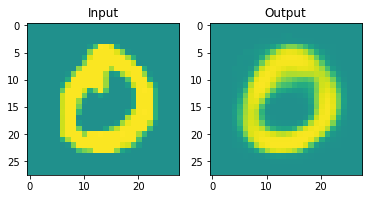

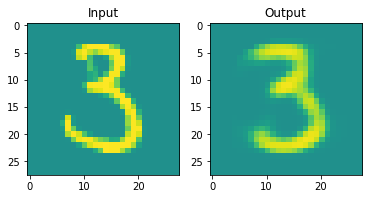

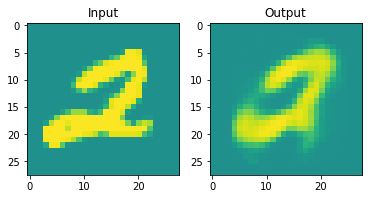

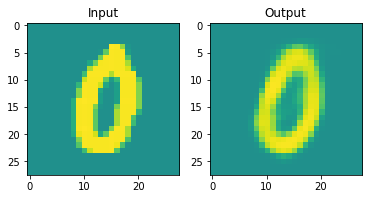

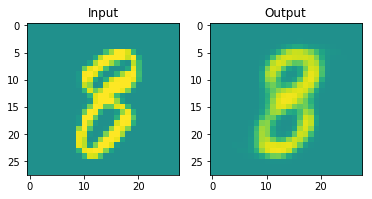

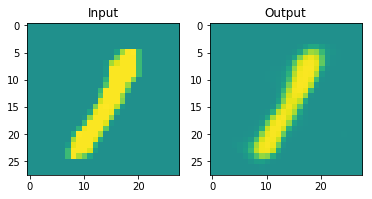

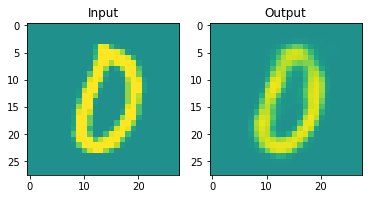

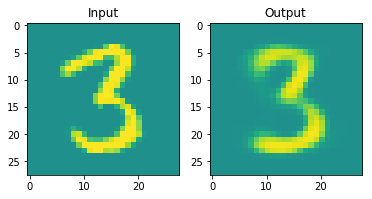

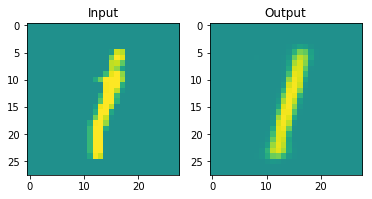

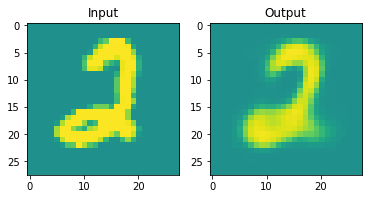

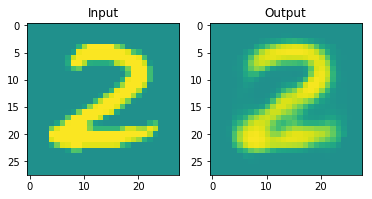

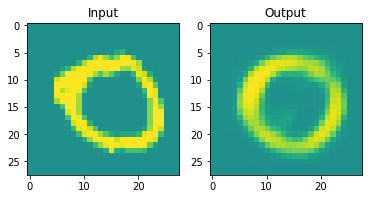

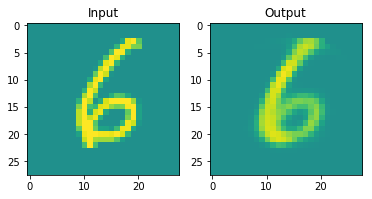

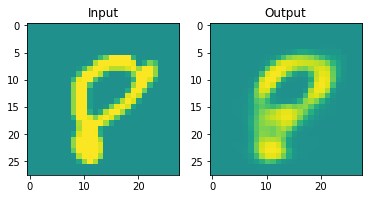

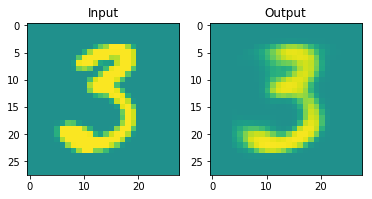

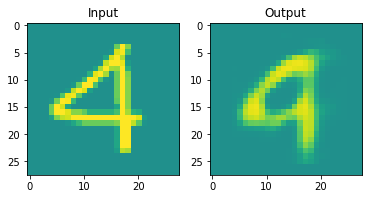

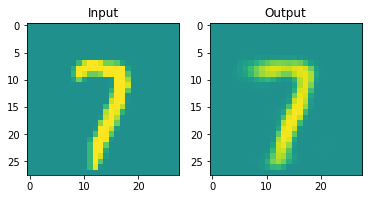

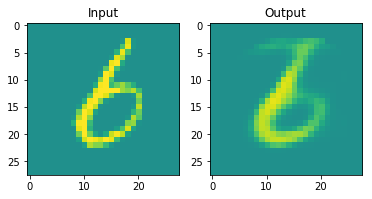

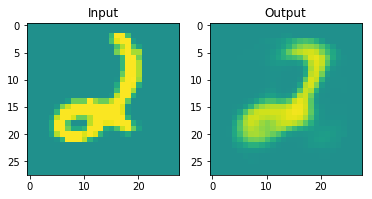

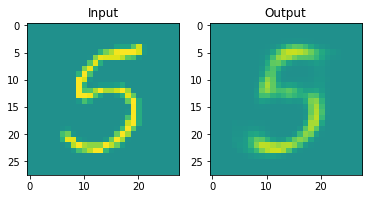

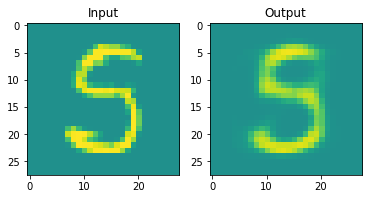

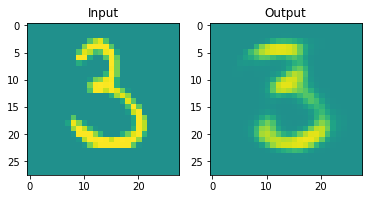

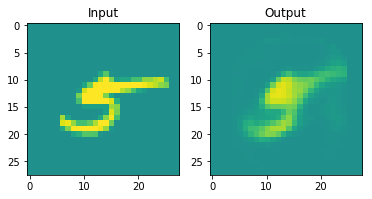

In [5]:
test_batch = mnist.test.next_batch(50)

outs = outputs.eval(feed_dict={
                    inputs: test_batch[0], learning_rate: lr})

for i in range(test_batch[0].shape[0]):
    fig = plt.figure()
    ax = fig.add_subplot(1,2,1)
    ax.imshow(test_batch[0][i,:].reshape((28,28)), vmin=-1.0, vmax=1.0)
    ax.set_title('Input')
    ax = fig.add_subplot(1,2,2)
    ax.imshow(outs[i,:].reshape((28,28)), vmin=-1.0, vmax=1.0)
    ax.set_title('Output')
    plt.show()

The evolution of the different loss components compared to the overall loss. Note, that is the same figure as above, just plotted with a better resolution. "loss" is the actual loss term that is optimized on consists of the other three components. "sparsity" measures how well the sparsity constraint within a layer is satisfied. "activity" evaluates the participation of all neurons (all neurons are involved in the network computation).

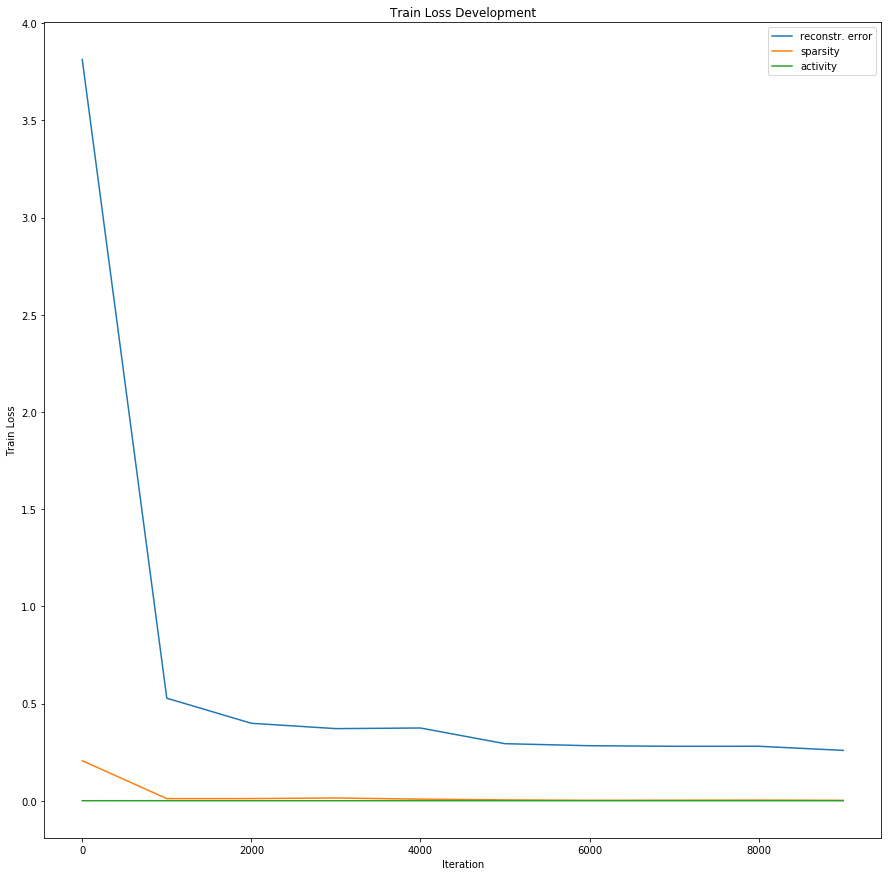

In [6]:
fig = plt.figure(figsize=(15,15))
xval, lval, erval, sval, aval = zip(*loss_values)
#plt.plot(xval, lval, label="loss")
plt.plot(xval, erval, label="reconstr. error")
plt.plot(xval, sval, label="sparsity")
plt.plot(xval, aval, label="activity")
plt.legend()
plt.title("Train Loss Development")
plt.xlabel("Iteration")
plt.ylabel("Train Loss")
plt.show()

### Get hidden layer representation (h2 activations) from trained model for all MNIST samples

In [7]:
train_images = mnist.train.images
test_images = mnist.test.images

hidden_activation_train = sess.run(h2, feed_dict={
            inputs: train_images, learning_rate: lr, \
            activity_trace_h1: at_h1, activity_trace_h2: at_h2, activity_trace_h3: at_h3})
hidden_activation_test = sess.run(h2, feed_dict={
            inputs: test_images, learning_rate: lr, \
            activity_trace_h1: at_h1, activity_trace_h2: at_h2, activity_trace_h3: at_h3})

### Train perceptron on h2 activs and plot test accuracy

In [8]:
from sklearn.linear_model import Perceptron
classifier = Perceptron(max_iter=1000, tol=1e-3)

classifier.fit(hidden_activation_train, np.argmax(mnist.train.labels, axis=1))
print("Test accuracy: %g" % classifier.score(hidden_activation_test, np.argmax(mnist.test.labels, axis=1)))

Test accuracy: 0.8016


### Train SVM on h2 activs and plot test accuracy

In [9]:
from sklearn.svm import SVC
classifier = SVC()

classifier.fit(hidden_activation_train, np.argmax(mnist.train.labels, axis=1))
print("Test accuracy: %g" % classifier.score(hidden_activation_test, np.argmax(mnist.test.labels, axis=1)))

Test accuracy: 0.9308


### Train Logistic Regression on h2 activs and plot test accuracy

In [10]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()

classifier.fit(hidden_activation_train, np.argmax(mnist.train.labels, axis=1))
print("Test accuracy: %g" % classifier.score(hidden_activation_test, np.argmax(mnist.test.labels, axis=1)))

Test accuracy: 0.8779


### Train NaiveBayes on h2 activs and plot test accuracy

In [11]:
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()

classifier.fit(hidden_activation_train, np.argmax(mnist.train.labels, axis=1))
print("Test accuracy: %g" % classifier.score(hidden_activation_test, np.argmax(mnist.test.labels, axis=1)))

Test accuracy: 0.809


### For comparison: How well Perceptron performs on the actual image data

For a perfect classifier, it should definately be easier to classify the actual image data, as the compressed image may include degenerated images (as seen in the above reconstructions). However, the degenerations are not that bad compared to the difficulties that should arise due to the much bigger feature space to learn for perceptron when operating on the original image space.

In [12]:
from sklearn.linear_model import Perceptron
classifier = Perceptron(max_iter=1000, tol=1e-3)

classifier.fit(mnist.train.images, np.argmax(mnist.train.labels, axis=1))
print("Test accuracy: %g" % classifier.score(mnist.test.images, np.argmax(mnist.test.labels, axis=1)))

Test accuracy: 0.8799
